<a href="https://colab.research.google.com/github/Jair-RM/Modelacion-Financiera/blob/main/Portafolio_intentos_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.6 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=98c343cc5629dbba3594083d01142b29dcd141c2c4630c4cee022194e197345f
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  15 of 15 completed


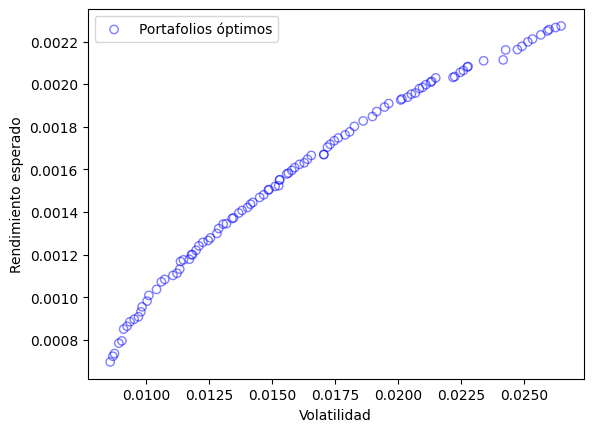

   Ticker      Peso  Inversión ($)
12     MA  0.400916    4009.159156
10     PG  0.379138    3791.380704
9     WMT  0.051704     517.035780
14     KO  0.051233     512.327152
3    AMZN  0.036616     366.158954
13   NFLX  0.025386     253.862613
0    AAPL  0.024681     246.810082
7       V  0.017708     177.080150
5    NVDA  0.009469      94.687413
6     JPM  0.004501      45.014097
1    MSFT  0.002941      29.409315
11    DIS  0.002864      28.643189
8     JNJ  0.001712      17.118937
2   GOOGL  0.000670       6.698816
4    TSLA  0.000120       1.196399


In [4]:
# Definir tickers de 15 acciones
# Puedes cambiar estos tickers por los que desees analizar
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "WMT", "PG", "DIS", "MA", "NFLX", "KO"]

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

# Descargar datos de cierre
datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy()

# Calcular rendimientos diarios
rend = datos.pct_change().dropna()

# Calcular media de rendimientos y matriz de covarianza
r = rend.mean().values
Cov = rend.cov().values

# Definir problema de optimización
class Portafolio(Problem):
    def __init__(self, mu, cov):
        self.mu = mu
        self.cov = cov
        super().__init__(n_var=15, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        rendimiento = x @ self.mu
        riesgo = np.sqrt(np.einsum('ij,jk,ik->i', x, self.cov, x))
        out["F"] = [riesgo, -rendimiento]
        out["G"] = np.abs(np.sum(x, axis=1) - 1.0) - 0.01

# Resolver problema
problem = Portafolio(r, Cov)
algorithm = NSGA2(pop_size=100)
res = minimize(problem, algorithm, ('n_gen', 300), seed=1, verbose=False)

# Obtener soluciones óptimas
X, F = res.opt.get("X", "F")
F[:, 1] *= -1  # Invertir rendimiento

# Graficar la frontera eficiente
plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento esperado")
plt.legend()
plt.show()

# Obtener el portafolio con mejor beneficio
mejor_idx = np.argmax(F[:, 1])
mejor_pesos = X[mejor_idx]

# Convertir pesos a inversión en dólares
capital_total = 10000
distribucion = mejor_pesos * capital_total

# Mostrar distribución de inversión
portafolio_optimo = pd.DataFrame({'Ticker': tickers, 'Peso': mejor_pesos, 'Inversión ($)': distribucion})
print(portafolio_optimo.sort_values(by='Peso', ascending=False))


[*********************100%***********************]  15 of 15 completed


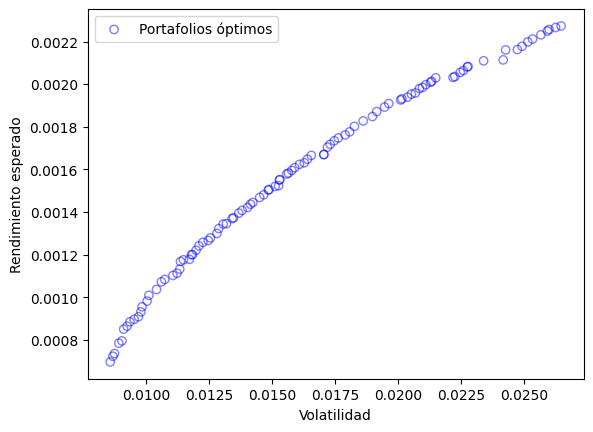

       Ticker  Num Acciones  Inversión ($)
Ticker                                    
TSLA       MA            14    3823.820068
NVDA       PG            34    3788.620010
WMT        KO             5     428.149986
GOOGL    AMZN             2     324.480011
AAPL     AAPL             1     223.850006
DIS     GOOGL             0       0.000000
AMZN     MSFT             0       0.000000
KO        JPM             0       0.000000
JPM      NVDA             0       0.000000
JNJ      TSLA             0       0.000000
MA          V             0       0.000000
NFLX      WMT             0       0.000000
MSFT      JNJ             0       0.000000
PG        DIS             0       0.000000
V        NFLX             0       0.000000


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

# Definir tickers de 15 acciones
# Puedes cambiar estos tickers por los que desees analizar
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "WMT", "PG", "DIS", "MA", "NFLX", "KO"]

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

# Descargar datos de cierre
datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy()

# Obtener precios actuales
precios_actuales = datos.iloc[-1]

# Calcular rendimientos diarios
rend = datos.pct_change().dropna()

# Calcular media de rendimientos y matriz de covarianza
r = rend.mean().values
Cov = rend.cov().values

# Definir problema de optimización
class Portafolio(Problem):
    def __init__(self, mu, cov, precios, capital_total):
        self.mu = mu
        self.cov = cov
        self.precios = precios
        self.capital_total = capital_total
        super().__init__(n_var=15, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        rendimiento = x @ self.mu
        riesgo = np.sqrt(np.einsum('ij,jk,ik->i', x, self.cov, x))

        # Convertir pesos a inversión en dólares
        distribucion = x * self.capital_total

        # Asegurar que las inversiones correspondan a múltiplos del precio de las acciones
        num_acciones = np.floor(distribucion / self.precios)
        distribucion_real = num_acciones * self.precios

        # Normalizar para que la suma no exceda el capital total
        if np.sum(distribucion_real) > self.capital_total:
            distribucion_real *= self.capital_total / np.sum(distribucion_real)

        out["F"] = [riesgo, -rendimiento]
        out["G"] = np.abs(np.sum(x, axis=1) - 1.0) - 0.01

# Resolver problema
capital_total = 10000
problem = Portafolio(r, Cov, precios_actuales.values, capital_total)
algorithm = NSGA2(pop_size=100)
res = minimize(problem, algorithm, ('n_gen', 300), seed=1, verbose=False)

# Obtener soluciones óptimas
X, F = res.opt.get("X", "F")
F[:, 1] *= -1  # Invertir rendimiento

# Graficar la frontera eficiente
plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento esperado")
plt.legend()
plt.show()

# Obtener el portafolio con mejor beneficio
mejor_idx = np.argmax(F[:, 1])
mejor_pesos = X[mejor_idx]

distribucion = mejor_pesos * capital_total
num_acciones = np.floor(distribucion / precios_actuales)
distribucion_real = num_acciones * precios_actuales

# Mostrar distribución de inversión
portafolio_optimo = pd.DataFrame({'Ticker': tickers, 'Num Acciones': num_acciones.astype(int), 'Inversión ($)': distribucion_real})
print(portafolio_optimo.sort_values(by='Inversión ($)', ascending=False))


[*********************100%***********************]  16 of 16 completed


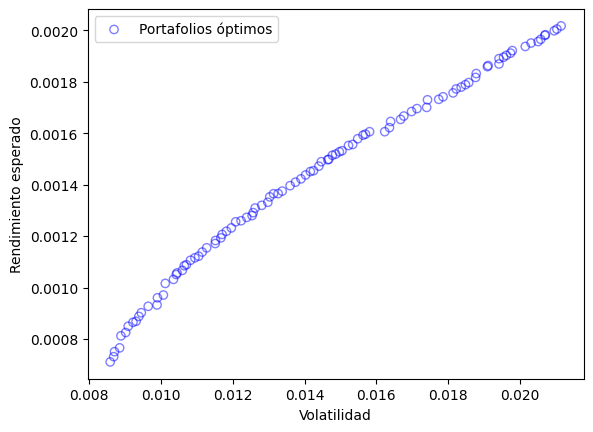

       Ticker  Num Acciones  Inversión ($)
Ticker                                    
NVDA      DIS            44    4902.920013
JPM       JPM             7    1736.839966
F        AMZN           141    1395.899946
TSLA     NFLX             3     819.390015
WMT         F             8     685.039978
AAPL     AAPL             1     223.850006
GOOGL    TSLA             1     162.240005
KO          V             1      70.739998
JNJ      NVDA             0       0.000000
DIS     GOOGL             0       0.000000
AMZN     MSFT             0       0.000000
MA        JNJ             0       0.000000
NFLX       PG             0       0.000000
MSFT      WMT             0       0.000000
PG         MA             0       0.000000
V          KO             0       0.000000
Total invertido: $9996.92


<ipython-input-8-995d0bb14820>:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_acciones[accion_barata_idx] += np.floor(dinero_restante / precios_actuales[accion_barata_idx])
<ipython-input-8-995d0bb14820>:87: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  num_acciones[accion_barata_idx] += np.floor(dinero_restante / precios_actuales[accion_barata_idx])


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

# Definir tickers de 16 acciones (agregamos una más barata para compensar dinero sobrante)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "WMT", "PG", "DIS", "MA", "NFLX", "KO", "F"]  # Se agregó Ford (F) como opción más barata

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

# Descargar datos de cierre
datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy()

# Obtener precios actuales
precios_actuales = datos.iloc[-1]

# Calcular rendimientos diarios
rend = datos.pct_change().dropna()

# Calcular media de rendimientos y matriz de covarianza
r = rend.mean().values
Cov = rend.cov().values

# Definir problema de optimización
class Portafolio(Problem):
    def __init__(self, mu, cov, precios, capital_total):
        self.mu = mu
        self.cov = cov
        self.precios = precios
        self.capital_total = capital_total
        super().__init__(n_var=16, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        rendimiento = x @ self.mu
        riesgo = np.sqrt(np.einsum('ij,jk,ik->i', x, self.cov, x))

        # Convertir pesos a inversión en dólares
        distribucion = x * self.capital_total

        # Asegurar que las inversiones correspondan a múltiplos del precio de las acciones
        num_acciones = np.floor(distribucion / self.precios)
        distribucion_real = num_acciones * self.precios

        # Ajustar para usar más capital disponible
        dinero_restante = self.capital_total - np.sum(distribucion_real)
        if dinero_restante > 0:
            accion_barata_idx = np.argmin(self.precios)
            num_acciones[accion_barata_idx] += np.floor(dinero_restante / self.precios[accion_barata_idx])
            distribucion_real = num_acciones * self.precios

        out["F"] = [riesgo, -rendimiento]
        out["G"] = np.abs(np.sum(x, axis=1) - 1.0) - 0.01

# Resolver problema
capital_total = 10000
problem = Portafolio(r, Cov, precios_actuales.values, capital_total)
algorithm = NSGA2(pop_size=100)
res = minimize(problem, algorithm, ('n_gen', 300), seed=1, verbose=False)

# Obtener soluciones óptimas
X, F = res.opt.get("X", "F")
F[:, 1] *= -1  # Invertir rendimiento

# Graficar la frontera eficiente
plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento esperado")
plt.legend()
plt.show()

# Obtener el portafolio con mejor beneficio
mejor_idx = np.argmax(F[:, 1])
mejor_pesos = X[mejor_idx]

distribucion = mejor_pesos * capital_total
num_acciones = np.floor(distribucion / precios_actuales)
distribucion_real = num_acciones * precios_actuales

# Ajustar para usar todo el capital disponible
dinero_restante = capital_total - np.sum(distribucion_real)
if dinero_restante > 0:
    accion_barata_idx = np.argmin(precios_actuales)
    num_acciones[accion_barata_idx] += np.floor(dinero_restante / precios_actuales[accion_barata_idx])
    distribucion_real = num_acciones * precios_actuales

# Mostrar distribución de inversión
portafolio_optimo = pd.DataFrame({'Ticker': tickers, 'Num Acciones': num_acciones.astype(int), 'Inversión ($)': distribucion_real})
print(portafolio_optimo.sort_values(by='Inversión ($)', ascending=False))

# Mostrar el total invertido
total_inversion = distribucion_real.sum()
print(f"Total invertido: ${total_inversion:.2f}")


[*********************100%***********************]  16 of 16 completed


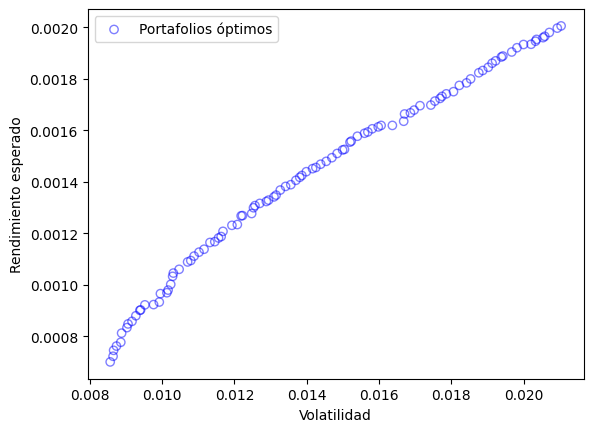

   Ticker  Num Acciones  Inversión ($)
11    DIS            46    5125.780014
6     JPM             8    1984.959961
3    AMZN            85     841.499968
15      F             7     599.409981
13   NFLX             2     546.260010
12     MA             3     506.130020
0    AAPL             1     223.850006
4    TSLA             1     162.240005
7       V             0       0.000000
5    NVDA             0       0.000000
1    MSFT             0       0.000000
2   GOOGL             0       0.000000
10     PG             0       0.000000
9     WMT             0       0.000000
8     JNJ             0       0.000000
14     KO             0       0.000000
Total invertido: $9990.13


In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize

# Definir tickers de 16 acciones (agregamos una más barata para compensar dinero sobrante)
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "JPM", "V", "JNJ", "WMT", "PG", "DIS", "MA", "NFLX", "KO", "F"]  # Se agregó Ford (F) como opción más barata

hoy = pd.Timestamp.today()
inicio = hoy - pd.Timedelta(days=365*5)

# Descargar datos de cierre
datos = yf.download(tickers, start=inicio, end=hoy)['Close'].copy()

# Obtener precios actuales
precios_actuales = datos.iloc[-1]

# Calcular rendimientos diarios
rend = datos.pct_change().dropna()

# Calcular media de rendimientos y matriz de covarianza
r = rend.mean().values
Cov = rend.cov().values

# Definir problema de optimización
class Portafolio(Problem):
    def __init__(self, mu, cov, precios, capital_total):
        self.mu = mu
        self.cov = cov
        self.precios = precios
        self.capital_total = capital_total
        super().__init__(n_var=16, n_obj=2, n_ieq_constr=1, xl=0.0, xu=1.0)

    def _evaluate(self, x, out, *args, **kwargs):
        rendimiento = x @ self.mu
        riesgo = np.sqrt(np.einsum('ij,jk,ik->i', x, self.cov, x))

        # Convertir pesos a inversión en dólares
        distribucion = x * self.capital_total

        # Asegurar que las inversiones correspondan a múltiplos del precio de las acciones
        num_acciones = np.floor(distribucion / self.precios.values)
        distribucion_real = num_acciones * self.precios.values

        # Ajustar para usar más capital disponible
        dinero_restante = self.capital_total - np.sum(distribucion_real)
        if dinero_restante > 0:
            accion_barata_idx = np.argmin(self.precios.values)
            num_acciones[accion_barata_idx] += np.floor(dinero_restante / self.precios.iloc[accion_barata_idx])
            distribucion_real = num_acciones * self.precios.values

        out["F"] = [riesgo, -rendimiento]
        out["G"] = np.abs(np.sum(x, axis=1) - 1.0) - 0.01

# Resolver problema
capital_total = 10000
problem = Portafolio(r, Cov, precios_actuales, capital_total)
algorithm = NSGA2(pop_size=100)
res = minimize(problem, algorithm, ('n_gen', 300), seed=1, verbose=False)

# Obtener soluciones óptimas
X, F = res.opt.get("X", "F")
F[:, 1] *= -1  # Invertir rendimiento

# Graficar la frontera eficiente
plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Portafolios óptimos")
plt.xlabel("Volatilidad")
plt.ylabel("Rendimiento esperado")
plt.legend()
plt.show()

# Obtener el portafolio con mejor beneficio
mejor_idx = np.argmax(F[:, 1])
mejor_pesos = X[mejor_idx]

distribucion = mejor_pesos * capital_total
num_acciones = np.floor(distribucion / precios_actuales.values)
distribucion_real = num_acciones * precios_actuales.values

# Ajustar para usar todo el capital disponible
dinero_restante = capital_total - np.sum(distribucion_real)
if dinero_restante > 0:
    accion_barata_idx = np.argmin(precios_actuales.values)
    num_acciones[accion_barata_idx] += np.floor(dinero_restante / precios_actuales.iloc[accion_barata_idx])
    distribucion_real = num_acciones * precios_actuales.values

# Mostrar distribución de inversión
portafolio_optimo = pd.DataFrame({'Ticker': tickers, 'Num Acciones': num_acciones.astype(int), 'Inversión ($)': distribucion_real})
print(portafolio_optimo.sort_values(by='Inversión ($)', ascending=False))

# Mostrar el total invertido
total_inversion = distribucion_real.sum()
print(f"Total invertido: ${total_inversion:.2f}")